In [1]:
%load_ext autoreload
%autoreload 2

import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

import neal
import dimod
import dwave_networkx as dnx
from dwave.system import DWaveSampler, EmbeddingComposite, LeapHybridSampler

import networkx as nx
import math

from itertools import combinations
from operator import itemgetter
from timeit import default_timer
from random import shuffle


from market import *
from utils import *

EPS = 1e-6
R0 = 0.0192

r0 = np.log(np.exp(R0)**(1/365))
r0

5.260273972608513e-05

In [2]:
# from pymoo.algorithms.soo.nonconvex.ga import GA
# from pymoo.factory import get_problem
# from pymoo.optimize import minimize

# problem = get_problem("g01")

# algorithm = GA(
#     pop_size=100,
#     eliminate_duplicates=True)

# res = minimize(problem,
#                algorithm,
#                seed=1,
#                verbose=False)

# print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

In [3]:
from dwave.system import LeapHybridSampler

# solver2 = LeapHybridSampler()
solver = LeapHybridSampler.default_solver
solver.update(name__regex=".*(?<!bulk)$")       # name shouldn't end with "bulk"
hsolver = LeapHybridSampler(solver=solver)      
hsolver.solver 

BQMSolver(id='hybrid_binary_quadratic_model_version2')

In [4]:
with open('ETF_list.pkl', 'rb') as fp:
    ETF_list = pickle.load(fp)
    
with open('crypto_list.pkl', 'rb') as fp:
    crypto_list = pickle.load(fp)

In [5]:
# sample_num = 600
# # ETF_num = int(sample_num*len(ETF_list)/(len(ETF_list) + len(crypto_list)))
# # crypto_num = int(sample_num*len(crypto_list)/(len(ETF_list) + len(crypto_list)))
# # sample_ticker = ETF_list[:ETF_num] + crypto_list[:crypto_num]
# # print(sample_ticker, ETF_num, crypto_num )
# sample_ticker = ETF_list[:6]

# market, t = get_time(Market, params = {'tickers' : sample_ticker, 'start_date' : '2018-08-24', 'end_date' : '2021-08-24'})
# portfolio, t = get_time(Portfolio, {'market' : market})
# portfolio.build_binary_portfolio(weighted = False, alpha = 0)

In [76]:
df_list = []
time_list = []
name_list = []
N_list = []
Sharp_list = []

# [16] [0.001,0.05,1e-3]
# [21]  [0.001,0.05,1e-3]
#  [33] [0.04,1,1e-3]
# [230] [0.05,2,1e-5]
# [426] [0.005,2,1e-5] или [0.005,2,1e-5*5] (не то масштаб, но хороший результат)
# [900] [0.02,2.4,1e-5]

# mark_num = [230] 
mark_num = [16, 21, 33, 230, 434, 900]

theta_storage = [
                 [1e-3,0.05,0.1], 
                 [1e-3,0.05,0.1], 
                 [1e-4,1,0.1], # 1e-3
                 [1e-7,1.8,0.1], # 1e-5
                 [1e-7,2,0.1], #1e-4
                 [1e-7,2.2,0.1] # 1e-5
                ]
# mark_num = [72, 100,150]#,250,300,350,450,500,700,800] [27,33,45,
# mark_num = [,10,15]
# mark_num = [3, 6, 10, 12, 15]

# mark_num = [10]

for N, theta_list in zip(mark_num, theta_storage):
    market, portfolio = build_market(sample_num = N) #, type_ = 'ETF'
    
    exact_params = {'size': market.N, 'name': 'exact', 'portfolio': portfolio, 'weighted': False}

    params_Ising_exact =  {
        'name': 'exact_Ising',
        'size': market.N,
        'portfolio' : portfolio,
        'sampler': dimod.ExactSolver(),
        'weighted' : False,
#         'theta' : [0.00001,0.005,1e-1],
#         'theta' : [0.001,0.5,1e-3],
        'theta' : theta_list,
        'market_num': min(20,market.N*2/3)}

    params_Ising_neal =  params_Ising_exact.copy()
    params_Ising_neal['sampler'] = neal.SimulatedAnnealingSampler()
    params_Ising_neal['name'] = 'neal_sim'
    params_Ising_Dwave =  params_Ising_exact.copy()
    params_Ising_Dwave['sampler'] = EmbeddingComposite(DWaveSampler())
    params_Ising_Dwave['name'] = 'quantum_neal'
    
    params_Ising_Dwave_hybrid =  params_Ising_exact.copy()
    params_Ising_Dwave_hybrid['sampler'] = hsolver
    params_Ising_Dwave_hybrid['name'] = 'quantum_hybrid'
    
    if market.N<20:

        df, t = get_time(get_effective_boundary, params = exact_params )
        df_list.append(df.copy())
        name_list.append('exact')
        time_list.append(t)
        N_list.append(portfolio.N)
        Sharp_list.append(df['sharp'][df['sharp']>0].mean())
        
    if market.N<25:

        df, t  = get_time(build_ising_effective_boundary, params = params_Ising_exact)
        df_list.append(df.copy())
        name_list.append('exact_Ising')
        time_list.append(t)
        N_list.append(portfolio.N)
        Sharp_list.append(df['sharp'][df['sharp']>0].mean())

    df, t  = get_time(build_ising_effective_boundary, params = params_Ising_neal)
    df_list.append(df.copy())
    name_list.append('neal_Ising')
    time_list.append(t)
    N_list.append(portfolio.N)
    Sharp_list.append(df['sharp'][df['sharp']>0].mean())
    
#     df, t  = get_time(build_ising_effective_boundary, params = params_Ising_Dwave_hybrid)
#     df_list.append(df.copy())
#     name_list.append('Dwave_Ising_hybrid')
#     time_list.append(t)
#     N_list.append(portfolio.N)
#     Sharp_list.append(df['sharp'][df['sharp']>0].mean())

#     df, t  = get_time(build_ising_effective_boundary, params = params_Ising_Dwave)
#     df_list.append(df.copy())
#     name_list.append('Dwave_Ising')
#     time_list.append(t)
#     N_list.append(portfolio.N)
#     Sharp_list.append(df['sharp'][df['sharp']>0].mean())



['IEFA', 'IEMG', 'BNDX', 'IXUS', 'QUAL', 'ARKK', 'ESGU', 'DGRO', 'VTIP', 'VLUE', 'GOVT', 'LINK-USD', 'DERO-USD', 'ENJ-USD', 'DOGE-USD'] 11 4
2018-08-24 2021-08-24
[*********************100%***********************]  15 of 15 completed
(1097, 15)
Market size: 15
--- 5.1590588092803955 seconds ---
--- 1.049041748046875e-05 seconds ---
--- 113.77987027168274 seconds ---
--- 13.834398984909058 seconds ---
--- 0.3258686065673828 seconds ---
['IEFA', 'IEMG', 'BNDX', 'IXUS', 'QUAL', 'ARKK', 'ESGU', 'DGRO', 'VTIP', 'VLUE', 'GOVT', 'IUSB', 'MTUM', 'VTEB', 'GSLC', 'LINK-USD', 'DERO-USD', 'ENJ-USD', 'DOGE-USD', 'THETA-USD'] 15 5
2018-08-24 2021-08-24
[*********************100%***********************]  20 of 20 completed
(1097, 20)
Market size: 20
--- 2.0360593795776367 seconds ---
--- 1.71661376953125e-05 seconds ---
--- 662.1117360591888 seconds ---
--- 0.4339632987976074 seconds ---
['IEFA', 'IEMG', 'BNDX', 'IXUS', 'QUAL', 'ARKK', 'ESGU', 'DGRO', 'VTIP', 'VLUE', 'GOVT', 'IUSB', 'MTUM', 'VTEB', '

[*********************100%***********************]  786 of 786 completed
(1097, 786)
Market size: 580
--- 269.70379400253296 seconds ---
--- 1.7881393432617188e-05 seconds ---
--- 120.36283111572266 seconds ---


In [164]:
df_list = []
time_list = []
name_list = []
N_list = []
Sharp_list = []

# mark_num = [230] 
mark_num = [16, 16, 16]

theta_storage = [
                 [5*1e-2,0.8,0.3],
#                  [1e-2,0.5,0.2],
#                  [1e-2,0.5,0.1],
                 [5*1e-2,0.8,0.05],
#                  [1e-2,0.5,0.02]
#                  [1e-2,0.5,0.01],
                 [5*1e-2,0.8,0.005]
                ]


# mark_num = [72, 100,150]#,250,300,350,450,500,700,800] [27,33,45,
# mark_num = [,10,15]
# mark_num = [3, 6, 10, 12, 15]

# mark_num = [10]
i = 0
for N, theta_list in zip(mark_num, theta_storage):
    market, portfolio = build_market(sample_num = N) #, type_ = 'ETF'
    
    exact_params = {'size': market.N, 'name': 'exact', 'portfolio': portfolio, 'weighted': False}

    params_Ising_exact =  {
        'name': 'exact_Ising',
        'size': market.N,
        'portfolio' : portfolio,
        'sampler': dimod.ExactSolver(),
        'weighted' : False,
#         'theta' : [0.00001,0.005,1e-1],
#         'theta' : [0.001,0.5,1e-3],
        'theta' : theta_list,
        'market_num': 8}

    params_Ising_neal =  params_Ising_exact.copy()
    params_Ising_neal['sampler'] = neal.SimulatedAnnealingSampler()
    params_Ising_neal['name'] = 'neal_sim'
    params_Ising_Dwave =  params_Ising_exact.copy()
    params_Ising_Dwave['sampler'] = EmbeddingComposite(DWaveSampler())
    params_Ising_Dwave['name'] = 'quantum_neal'
    
    params_Ising_Dwave_hybrid =  params_Ising_exact.copy()
    params_Ising_Dwave_hybrid['sampler'] = hsolver
    params_Ising_Dwave_hybrid['name'] = 'quantum_hybrid'
    
    if ((market.N<20) &(i<1)):

        df, t = get_time(get_effective_boundary, params = exact_params )
        df_list.append(df.copy())
        name_list.append('exact')
        time_list.append(t)
        N_list.append(portfolio.N)
        Sharp_list.append(df['sharp'][df['sharp']>0].mean())
        
#     if market.N<25:

#         df, t  = get_time(build_ising_effective_boundary, params = params_Ising_exact)
#         df_list.append(df.copy())
#         name_list.append('exact_Ising')
#         time_list.append(t)
#         N_list.append(portfolio.N)
#         Sharp_list.append(df['sharp'][df['sharp']>0].mean())

    df, t  = get_time(build_ising_effective_boundary, params = params_Ising_neal)
    df_list.append(df.copy())
    name_list.append('neal_Ising')
    time_list.append(t)
    N_list.append(portfolio.N)
    Sharp_list.append(df['sharp'][df['sharp']>0].mean())
    
#     df, t  = get_time(build_ising_effective_boundary, params = params_Ising_Dwave_hybrid)
#     df_list.append(df.copy())
#     name_list.append('Dwave_Ising_hybrid')
#     time_list.append(t)
#     N_list.append(portfolio.N)
#     Sharp_list.append(df['sharp'][df['sharp']>0].mean())

#     df, t  = get_time(build_ising_effective_boundary, params = params_Ising_Dwave)
#     df_list.append(df.copy())
#     name_list.append('Dwave_Ising')
#     time_list.append(t)
#     N_list.append(portfolio.N)
#     Sharp_list.append(df['sharp'][df['sharp']>0].mean())

    i+=1



['IEFA', 'IEMG', 'BNDX', 'IXUS', 'QUAL', 'ARKK', 'ESGU', 'DGRO', 'VTIP', 'VLUE', 'GOVT', 'LINK-USD', 'DERO-USD', 'ENJ-USD', 'DOGE-USD'] 11 4
2018-08-24 2021-08-24
[*********************100%***********************]  15 of 15 completed
(1097, 15)
Market size: 15
--- 3.6841113567352295 seconds ---
--- 1.1682510375976562e-05 seconds ---
--- 104.26992273330688 seconds ---
--- 0.28416943550109863 seconds ---
['IEFA', 'IEMG', 'BNDX', 'IXUS', 'QUAL', 'ARKK', 'ESGU', 'DGRO', 'VTIP', 'VLUE', 'GOVT', 'LINK-USD', 'DERO-USD', 'ENJ-USD', 'DOGE-USD'] 11 4
2018-08-24 2021-08-24
[*********************100%***********************]  15 of 15 completed
(1097, 15)
Market size: 15
--- 2.3892762660980225 seconds ---
--- 9.5367431640625e-06 seconds ---
--- 0.27546215057373047 seconds ---
['IEFA', 'IEMG', 'BNDX', 'IXUS', 'QUAL', 'ARKK', 'ESGU', 'DGRO', 'VTIP', 'VLUE', 'GOVT', 'LINK-USD', 'DERO-USD', 'ENJ-USD', 'DOGE-USD'] 11 4
2018-08-24 2021-08-24
[*********************100%***********************]  15 of 15 co

In [165]:
list(np.array([N_list, name_list, time_list, Sharp_list]).T)

[array(['15', 'exact', '104.26992273330688', '0.960426069878167'],
       dtype='<U21'),
 array(['15', 'neal_Ising', '0.28416943550109863', '1.6287181080984359'],
       dtype='<U21'),
 array(['15', 'neal_Ising', '0.27546215057373047', '1.7792720182111157'],
       dtype='<U21'),
 array(['15', 'neal_Ising', '0.2662217617034912', '1.807816439109145'],
       dtype='<U21')]

In [166]:
# market, t = get_time(Market, params = {'tickers' : market.tickers[:10], 'start_date' : '2018-08-24', 'end_date' : '2021-08-24'})
# portfolio, t = get_time(Portfolio, {'market' : market})

In [167]:
def plot_beautyful(x_arr, y_arr, x_label = None, y_label = None, title = None, fontsize = 15,
                   title_fontsize = 17, figsize = (6,6), labelsize = 16,
                   markersize = 8, marker = 'o', linewidth = 3, label = None, show = False, set_fig = False):
    if set_fig == True:
        plt.figure(figsize=figsize, dpi=160)
    plt.plot(x_arr, y_arr, linewidth = linewidth, marker = marker, markersize = markersize, label = label)
    plt.xlabel(x_label, fontsize=fontsize)
    plt.ylabel(y_label, fontsize=fontsize)
    plt.xticks(fontsize = labelsize)
    plt.yticks(fontsize = labelsize)
    plt.title(title, fontsize=title_fontsize)
    plt.grid()
    if show == True:   
        plt.show()

--- 0.32619571685791016 seconds ---


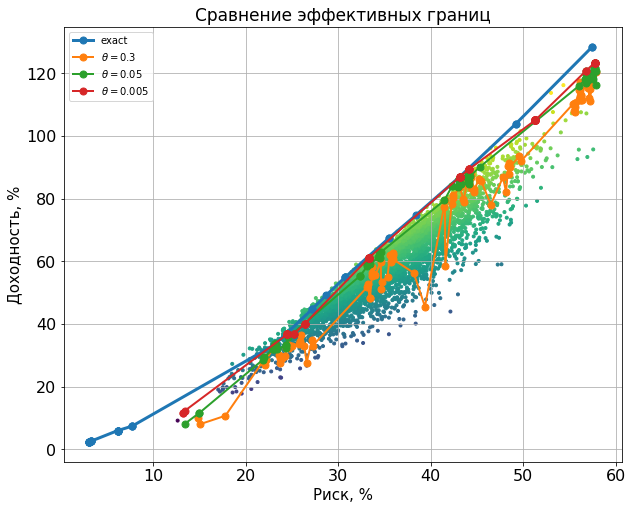

In [168]:
plt.figure(figsize=(10,8))
plt.title('Сравнение эффективных границ')
ts = [[0,0,0]]
ts.extend(theta_storage)

get_time(drow_cloud, params = {'portfolio': portfolio, 'N' : 4000})

for name, df, t in zip(name_list, df_list, ts):
    df = df.sort_values(by = 'risk')
#     df = df.sort_values(by = 'gamma')
    if name == 'exact':
#         plt.plot(df['risk'], df['return'], marker = '.', markersize = 14, label = r'exact')
        plot_beautyful(df['risk'], df['return'], x_label = r'Риск, %', y_label = r'Доходность, %', title = None, fontsize = 15,
                   title_fontsize = 17, figsize = (6,6), labelsize = 16,
                   markersize = 14, marker = '.', linewidth = 3, label = r'exact')
    else:    
#         plt.plot(df['risk'], df['return'], marker = '.', markersize = 14, label = r'$\theta = $' + str(t[2]))
        plot_beautyful(df['risk'], df['return'], x_label = r'Риск, %', y_label = r'Доходность, %', title = r'Сравнение эффективных границ', fontsize = 15,
                   title_fontsize = 17, figsize = (6,6), labelsize = 16,
                   markersize = 14, marker = '.', linewidth = 2, label = r'$\theta = $' + str(t[2]))
    plt.grid()
    plt.legend()

plt.show()

In [125]:
df_list[0]

,gamma,risk,return,sharp,size,time,name,mask,tickers
0,0.480818,23.784215,28.326829,1.110267,15.0,0.002852,neal_sim,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
1,0.462371,34.559597,60.907654,1.706839,15.0,0.002098,neal_sim,"[1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
2,0.444632,34.402663,61.116859,1.720706,15.0,0.001888,neal_sim,"[1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
3,0.427574,23.155932,31.900769,1.294734,15.0,0.001947,neal_sim,"[1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
4,0.411170,27.872374,35.497233,1.204678,15.0,0.002037,neal_sim,"[1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
...,...,...,...,...,...,...,...,...,...
95,0.011694,56.361713,111.282265,1.940364,15.0,0.002014,neal_sim,"[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
96,0.011245,56.361713,111.282265,1.940364,15.0,0.002050,neal_sim,"[0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
97,0.010814,56.719964,117.239481,2.033137,15.0,0.001994,neal_sim,"[1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
98,0.010399,57.697070,121.784057,2.077472,15.0,0.001999,neal_sim,"[1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."


In [69]:
full_df = pd.concat(df_list)
full_df

,gamma,risk,return,sharp,size,time,name,mask,tickers
0,1.000000,57.487828,128.539061,2.202537,15.0,2.745662,exact,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
1,2.000000,57.487828,128.539061,2.202537,15.0,2.844986,exact,"[1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
2,3.000000,49.229432,103.946410,2.072468,15.0,2.748675,exact,"[1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
3,4.000000,49.229432,103.946410,2.072468,15.0,2.842941,exact,"[1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
4,5.000000,43.183824,87.095663,1.972397,15.0,2.586220,exact,"[1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
...,...,...,...,...,...,...,...,...,...
95,0.001169,52.176348,105.769805,1.990362,15.0,0.001982,neal_sim,"[1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
96,0.001125,52.175715,105.799756,1.990960,15.0,0.001985,neal_sim,"[1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
97,0.001081,57.742780,123.427640,2.104291,15.0,0.001984,neal_sim,"[1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
98,0.001040,52.263830,105.690135,1.985506,15.0,0.001987,neal_sim,"[1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."


In [81]:
full_df['mask'].values[3].sum()

7

In [82]:
full_df[40:44]['mask'].values

array([array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0], dtype=int8),
       array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0], dtype=int8),
       array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0], dtype=int8),
       array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0], dtype=int8)],
      dtype=object)

In [83]:
full_df[full_df['name'] == 'neal_sim']

,gamma,risk,return,sharp,size,time,name,mask,tickers
0,1.071519e-03,46.916678,92.009057,1.920193,15.0,0.003078,neal_sim,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
1,1.148154e-03,47.853531,91.474457,1.871428,15.0,0.002290,neal_sim,"[1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
2,1.230269e-03,46.476586,89.856567,1.892062,15.0,0.002085,neal_sim,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
3,1.318257e-03,46.292007,90.049574,1.903775,15.0,0.002026,neal_sim,"[1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
4,1.412538e-03,46.311249,87.950518,1.857659,15.0,0.002353,neal_sim,"[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1]","[ARKK, BNDX, DERO-USD, DGRO, DOGE-USD, ENJ-USD..."
...,...,...,...,...,...,...,...,...,...
95,1.966513e-07,92.427375,212.019293,2.273128,580.0,0.919397,neal_sim,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ACSI, ACWF, ADA-USD, ADME, ADX-USD, AEON-USD,..."
96,1.660629e-07,93.492408,212.145608,2.248585,580.0,0.912718,neal_sim,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ACSI, ACWF, ADA-USD, ADME, ADX-USD, AEON-USD,..."
97,1.402324e-07,93.869191,212.427586,2.242563,580.0,0.924845,neal_sim,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ACSI, ACWF, ADA-USD, ADME, ADX-USD, AEON-USD,..."
98,1.184198e-07,93.393326,212.340276,2.253055,580.0,0.968042,neal_sim,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[ACSI, ACWF, ADA-USD, ADME, ADX-USD, AEON-USD,..."


In [84]:
full_df.to_excel('results/Full_data_{}.xlsx'.format(time.time()))

In [85]:
df_properties = pd.DataFrame(np.array([N_list, name_list, time_list, Sharp_list]).T, columns = ['N','opt_method', 'time','Sharp_avg'])

In [86]:
df_properties.to_excel('results/Prop_data_{}.xlsx'.format(time.time()))

In [173]:
cd results/

/home/stas/работа/кванты работа/scripts/results


In [174]:
ls

 all_meth10_12_14_16.xlsx            Prop_data_1634867126.2259493.xlsx
 ETF10full.xlsx                      Prop_data_1634914458.2758718.xlsx
 ETF10prop.xlsx                      Prop_data_1635367856.7198186.xlsx
 Full_data_1635377157.2949598.xlsx   Prop_data_1635377158.5493157.xlsx
 Full_data_1635379019.270272.xlsx    Prop_data_1635379019.3865044.xlsx
 Full_data_1635381092.6199439.xlsx   Prop_data_1635381092.921715.xlsx
 Full_data_1635382219.2214017.xlsx   Prop_data_1635382219.440999.xlsx
 Full_data_1635941257.8228116.xlsx   Prop_data_1635941259.3058667.xlsx
 Full_data_1635968290.55933.xlsx     Prop_data_1635968292.031142.xlsx
 Full_data_1636681170.630926.xlsx    Prop_data_1636681171.0528116.xlsx
 Full_data_1636722313.5032709.xlsx   Prop_data_1636738079.5155456.xlsx
 Full_data_1636738078.4831617.xlsx   Prop_data_1637159179.7034194.xlsx
 Full_data_1637159179.1521118.xlsx   Prop_data_1637161514.9099267.xlsx
 Full_data_1637161514.5589118.xlsx   Prop_data_1637173938.498993.xlsx
 Full_data

In [205]:
df = pd.read_excel('Method_comp.xlsx')

In [206]:
df

,Unnamed: 0,gamma,risk,return,sharp,size,time,name,mask,tickers
0,0,1.000000e+00,57.487828,128.539061,2.202537,15,3.008454,exact,[1 0 1 0 1 0 1 0 0 0 0 1 1 0 0],"['ARKK', 'BNDX', 'DERO-USD', 'DGRO', 'DOGE-USD..."
1,1,2.000000e+00,57.487828,128.539061,2.202537,15,2.816203,exact,[1 0 1 0 1 0 1 0 0 0 0 1 1 0 0],"['ARKK', 'BNDX', 'DERO-USD', 'DGRO', 'DOGE-USD..."
2,2,3.000000e+00,49.229432,103.946410,2.072468,15,2.824522,exact,[1 0 1 0 1 0 1 1 0 0 0 1 1 0 0],"['ARKK', 'BNDX', 'DERO-USD', 'DGRO', 'DOGE-USD..."
3,3,4.000000e+00,49.229432,103.946410,2.072468,15,2.800140,exact,[1 0 1 0 1 0 1 1 0 0 0 1 1 0 0],"['ARKK', 'BNDX', 'DERO-USD', 'DGRO', 'DOGE-USD..."
4,4,5.000000e+00,43.183824,87.095663,1.972397,15,2.832147,exact,[1 0 1 0 1 0 1 1 0 0 0 1 1 0 1],"['ARKK', 'BNDX', 'DERO-USD', 'DGRO', 'DOGE-USD..."
...,...,...,...,...,...,...,...,...,...,...
835,95,1.966513e-07,92.427375,212.019293,2.273128,580,0.919397,neal_sim,[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"['ACSI', 'ACWF', 'ADA-USD', 'ADME', 'ADX-USD',..."
836,96,1.660629e-07,93.492408,212.145608,2.248585,580,0.912718,neal_sim,[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"['ACSI', 'ACWF', 'ADA-USD', 'ADME', 'ADX-USD',..."
837,97,1.402324e-07,93.869191,212.427586,2.242563,580,0.924845,neal_sim,[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"['ACSI', 'ACWF', 'ADA-USD', 'ADME', 'ADX-USD',..."
838,98,1.184198e-07,93.393326,212.340276,2.253055,580,0.968042,neal_sim,[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"['ACSI', 'ACWF', 'ADA-USD', 'ADME', 'ADX-USD',..."


In [207]:
df_list = []
name_list = []
N_list = []
dl = list(df.groupby(by = ['name','size'], as_index = False))
for d in dl:
    df_list.append(d[1])
    name_list.append(d[1]['name'].values[0])
    N_list.append(d[1]['size'].values[0])
    

In [208]:
df_list

[    Unnamed: 0  gamma       risk      return     sharp  size      time   name  \
 0            0    1.0  57.487828  128.539061  2.202537    15  3.008454  exact   
 1            1    2.0  57.487828  128.539061  2.202537    15  2.816203  exact   
 2            2    3.0  49.229432  103.946410  2.072468    15  2.824522  exact   
 3            3    4.0  49.229432  103.946410  2.072468    15  2.800140  exact   
 4            4    5.0  43.183824   87.095663  1.972397    15  2.832147  exact   
 5            5    6.0  43.183824   87.095663  1.972397    15  2.794106  exact   
 6            6    7.0  38.463930   74.882216  1.896900    15  2.878569  exact   
 7            7    8.0  35.487483   67.400388  1.845169    15  2.838593  exact   
 8            8    9.0  35.487483   67.400388  1.845169    15  2.809615  exact   
 9            9   10.0  30.748521   54.901694  1.723065    15  2.830446  exact   
 10          10   11.0  30.748521   54.901694  1.723065    15  2.928064  exact   
 11          11 

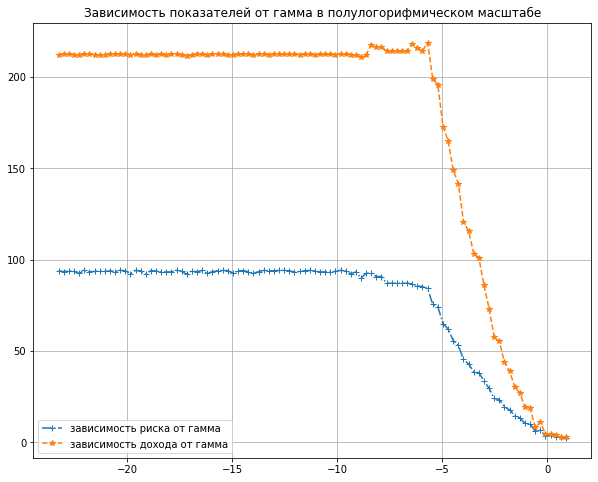

In [210]:
plt.figure(figsize=(10,8))
plt.title('Зависимость показателей от гамма в полулогорифмическом масштабе')
plt.plot(np.log2(df_list[-1]['gamma']),df_list[-1]['risk'],linestyle = '-.', marker = '+', label = 'зависимость риска от гамма')
plt.plot(np.log2(df_list[-1]['gamma']),df_list[-1]['return'],linestyle = '--', marker = '*', label = 'зависимость дохода от гамма')
plt.grid()
plt.legend()
plt.show()

In [215]:
name_list, N_list

(['exact',
  'exact_Ising',
  'exact_Ising',
  'neal_sim',
  'neal_sim',
  'neal_sim',
  'neal_sim',
  'neal_sim',
  'neal_sim'],
 [15, 15, 20, 15, 20, 30, 200, 357, 580])

--- 0.3292410373687744 seconds ---


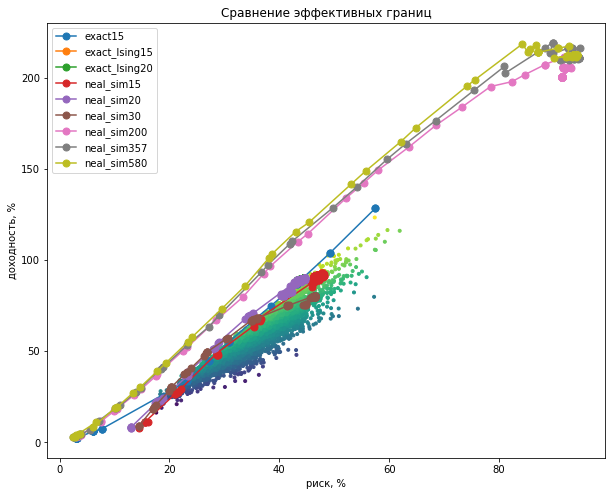

In [217]:
plt.figure(figsize=(10,8))
plt.title('Сравнение эффективных границ')

get_time(drow_cloud, params = {'portfolio': portfolio, 'N' : 4000})
i = 0
for name, df, N in zip(name_list, df_list, N_list):

    plt.plot(df['risk'], df['return'], marker = '.', markersize = 14, label = name + str(N))

    plt.grid()
    plt.legend()
    i+=1

plt.show()

--- 0.3301982879638672 seconds ---


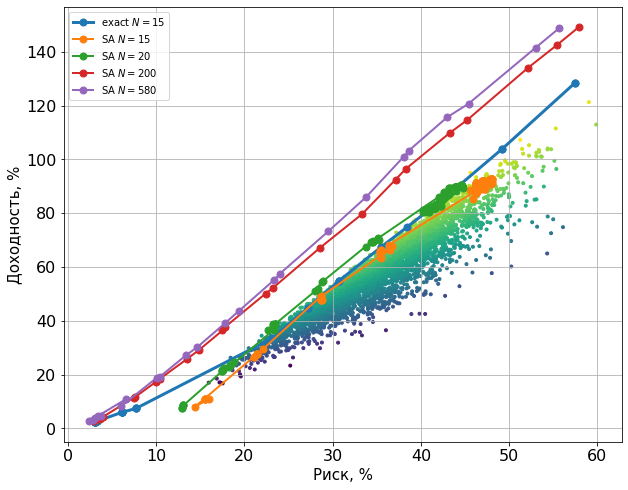

In [226]:
plt.figure(figsize=(10,8))
plt.title('Сравнение эффективных границ')

get_time(drow_cloud, params = {'portfolio': portfolio, 'N' : 4000})
i = 0
for name, df, N in zip(name_list, df_list, N_list):
    if (i == 0):
        plot_beautyful(df['risk'], df['return'], x_label = r'Риск, %', y_label = r'Доходность, %', title = None, fontsize = 15,
                   title_fontsize = 17, figsize = (6,6), labelsize = 16,
                   markersize = 14, marker = '.', linewidth = 3, label = r'exact $N=$' + str(N))
    if ((i == 3)|(i == 4)|(i == 6)|(i == 8)):
        plot_beautyful(df['risk'][df['risk']<=60], df['return'][df['risk']<=60], x_label = r'Риск, %', y_label = r'Доходность, %', title = None, fontsize = 15,
                   title_fontsize = 17, figsize = (6,6), labelsize = 16,
                   markersize = 14, marker = '.', linewidth = 2, label = r'SA $N=$' + str(N))
    plt.grid()
    plt.legend()
#     plt.xlim([-5, 60])
#     plt.ylim([-5, 180])
    i+=1

plt.show()

In [20]:
df_properties

,N,opt_method,time,Sharp_avg
0,15,exact,102.23208236694336,0.960426069878167
1,15,exact_Ising,12.343215942382812,1.8997471051289763
2,15,neal_Ising,0.28807616233825684,1.670555703560926
3,20,exact_Ising,580.0484139919281,2.2308249817340307
4,20,neal_Ising,0.3231546878814697,1.7836010351724239
5,30,neal_Ising,0.5452971458435059,1.417522656134232
6,200,neal_Ising,18.90661907196045,0.9896472467455895
7,357,neal_Ising,45.9126923084259,1.1939735218104723
8,580,neal_Ising,108.79315567016602,0.8827140491044826


In [21]:
portfolio.get_portfolio().head()

,ticker,weight
0,ACSI,0.047145
1,ACWF,0.164009
2,ADA-USD,0.132667
3,ADME,0.037268
4,ADX-USD,0.049153


In [273]:
def build_solution(portfolio, sampler, theta = [1,1/8,1e-2], weighted = False, market_num = 10):
    portfolio.build_Ising_hamiltonian(theta, weighted = False, market_num = market_num)
    J,h = portfolio.get_hamiltonian()

    sampleset = sampler.sample_ising(h, J)
    mask = np.array(list(sampleset.first.sample.values()))
    mask[mask == -1] = 0
    
    portfolio.build_binary_portfolio(weighted = False, alpha = 0 , mask = list(mask))

In [274]:
build_solution(portfolio, sampler = neal.SimulatedAnnealingSampler() , theta = [1,1/7,1e-2], weighted = False, market_num = 10)

In [275]:
portfolio.get_portfolio()

,ticker,weight
9,GSLC,0.083333
10,NOBL,0.083333
12,FPE,0.083333
58,HACK,0.083333
67,GBIL,0.083333
112,FCOM,0.083333
131,SILJ,0.083333
144,ONEY,0.083333
284,FIBR,0.083333
286,SGDJ,0.083333


In [175]:
portfolio.get_Sharp(), portfolio.get_risk(period = 365)*100,  portfolio.get_profit(period = 365)*100

(3.6520918067427512, 20.466708864984238, 76.66629975679817)

In [177]:
df_list[-1].head()

,gamma,risk,return,sharp,mask
0,0.050000,24.099261,71.434440,2.884505,"[0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, ..."
1,0.052632,24.099261,71.434440,2.884505,"[0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, ..."
2,0.055556,24.099261,71.434440,2.884505,"[0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, ..."
3,0.058824,24.099261,71.434440,2.884505,"[0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, ..."
4,0.062500,26.698725,75.279877,2.747692,"[0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, ..."


In [188]:
portfolio.get_portfolio()

,ticker,weight
1,IEMG,0.1
4,QUAL,0.1
13,VTEB,0.1
14,GSLC,0.1
18,FNDX,0.1
29,PDBC,0.1
32,ICSH,0.1
35,LINK-USD,0.1
40,KNC-USD,0.1
42,ADA-USD,0.1


In [190]:
sampler.properties

{'num_qubits': 5760,
 'qubits': [30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  158,
  159,
  160,
  161,
  162,
  163,
  164,
  165,
  166,
  167,
  168,
  169,
  170,
  171,
  172,
  173,
  174,
  175,
  176,
  177,
  1

In [68]:
market, portfolio = build_market(sample_num = 700)

['IEFA', 'IEMG', 'BNDX', 'IXUS', 'QUAL', 'ARKK', 'ESGU', 'DGRO', 'VTIP', 'VLUE', 'GOVT', 'IUSB', 'MTUM', 'VTEB', 'GSLC', 'NOBL', 'ARKG', 'FPE', 'FNDX', 'SRLN', 'LMBS', 'ESGE', 'MOAT', 'FNDF', 'HYLB', 'ESGD', 'DGRW', 'FTEC', 'INDA', 'PDBC', 'ISTB', 'ARKW', 'ICSH', 'KWEB', 'RDVY', 'IEUR', 'SHYG', 'ANGL', 'NEAR', 'SPYD', 'SJNK', 'FNDE', 'FNDA', 'CIBR', 'XLRE', 'FTSM', 'XSOE', 'BOND', 'QYLD', 'SPSM', 'XT', 'VIGI', 'IAGG', 'IQLT', 'REET', 'JETS', 'FALN', 'TOTL', 'VWOB', 'GSIE', 'SPHD', 'FHLC', 'HEFA', 'NFRA', 'FV', 'VNLA', 'VYMI', 'FNDC', 'ARKQ', 'COMT', 'BOTZ', 'FTSL', 'SLQD', 'BSCM', 'FMB', 'HACK', 'JHMM', 'HYLS', 'ASHR', 'BSCN', 'EMLP', 'FBND', 'RODM', 'PTLC', 'VRP', 'GBIL', 'FREL', 'ROBO', 'FNCL', 'ICVT', 'FTGC', 'TDIV', 'BSCL', 'QDF', 'IBDO', 'BSCO', 'FDIS', 'PSC', 'JPHY', 'IBDN', 'URTH', 'XMLV', 'IBDP', 'IBDM', 'FINX', 'HYEM', 'GEM', 'FPXI', 'IPAY', 'MJ', 'EMQQ', 'QLTA', 'SPYX', 'LRGF', 'SDOG', 'IBDQ', 'LDUR', 'FUTY', 'XSLV', 'IPAC', 'IVLU', 'FTXR', 'FDVV', 'USFR', 'NULV', 'AGGY', 'PI

In [5]:
sample_num = 200
ETF_num = int(sample_num*len(ETF_list)/(len(ETF_list) + len(crypto_list)))
crypto_num = int(sample_num*len(crypto_list)/(len(ETF_list) + len(crypto_list)))
sample_ticker = ETF_list[:ETF_num] + crypto_list[:crypto_num]
# print(sample_ticker, ETF_num, crypto_num )
# sample_ticker = ETF_list[:6]

market, t = get_time(Market, params = {'tickers' : sample_ticker, 'start_date' : '2018-08-24', 'end_date' : '2021-08-24'})
portfolio, t = get_time(Portfolio, {'market' : market})
portfolio.build_binary_portfolio(weighted = False, alpha = 0)

portfolio.build_Ising_hamiltonian(theta = [1e-3,1,0.1], weighted = False, market_num = 20)
J,h = portfolio.get_hamiltonian()

2018-08-24 2021-08-24
[*********************100%***********************]  199 of 199 completed
(1097, 199)
Market size: 175
--- 20.657671451568604 seconds ---
--- 2.288818359375e-05 seconds ---


In [6]:
import networkx as nx
import dwave_networkx as dnx
from dwave.system import DWaveSampler, EmbeddingComposite, DWaveCliqueSampler, FixedEmbeddingComposite

import random
from dwave.cloud import Client
from minorminer import busclique
import dwave_networkx
from minorminer import find_embedding

import networkx as nx
import dwave_networkx as dnx
import minorminer.layout as mml

# from dwave.cloud import Client
# with Client.from_config() as client:      # doctest: +SKIP
#     solver = client.get_solver()
# EmbeddingComposite()

    


In [7]:
market.N

175

In [9]:


grid_graph = nx.generators.lattice.grid_2d_graph(3, 3)
C = dnx.chimera_graph(2,1)

embedding = mml.find_embedding(grid_graph, C)
print(embedding)

{(0, 0): [2], (1, 0): [7], (0, 1): [10, 15], (1, 1): [0, 8], (0, 2): [11], (1, 2): [12], (2, 0): [3], (2, 1): [5], (2, 2): [1, 9]}


In [10]:
# C =  dnx.pegasus_graph(16)  #dnx.chimera_graph(u, u) # 
C = dnx.chimera_graph(16, 16, 4)
embedding = busclique.find_clique_embedding(nodes = 64, g = C)
a = list(embedding.values())
b = []
for ai in a:
    b.extend(list(ai))
b = np.array(b)
len(np.unique(b))

1088

In [11]:
from dwave_qbsolv import QBSolv
import neal
import itertools
import random

In [16]:
sampler = dimod.ExactSolver()
exact_list = []
N_list_e = []

for n in range(1,25):
    t = time.time()
    qubo_size = n
    Q = {t: random.uniform(-1, 1) for t in itertools.product(range(qubo_size), repeat=2)}
    res = sampler.sample_qubo(Q)
    dt = time.time() - t
    exact_list.append(dt)
    N_list_e.append(qubo_size)
    


In [171]:
exact_list[-1], sim_list[-1]

(128.40242719650269, 44.8028085231781)

In [14]:
sampler = neal.SimulatedAnnealingSampler()
sim_list = []
N_list = []

for n in range(1,13):
    
    qubo_size = 2**n
    Q = {t: random.uniform(-1, 1) for t in itertools.product(range(qubo_size), repeat=2)}
    t = time.time()
    res = sampler.sample_qubo(Q)
    dt = time.time() - t
    sim_list.append(dt)
    N_list.append(qubo_size)

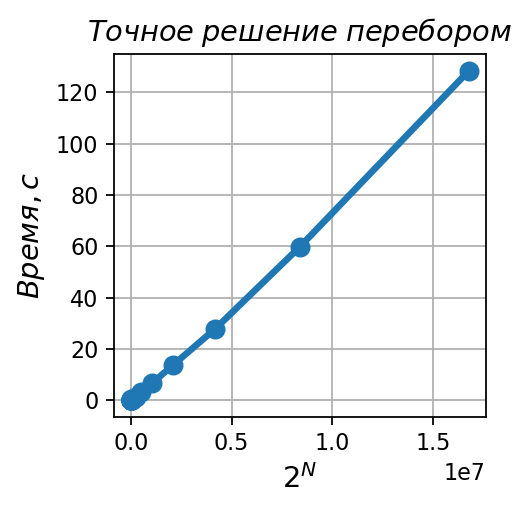

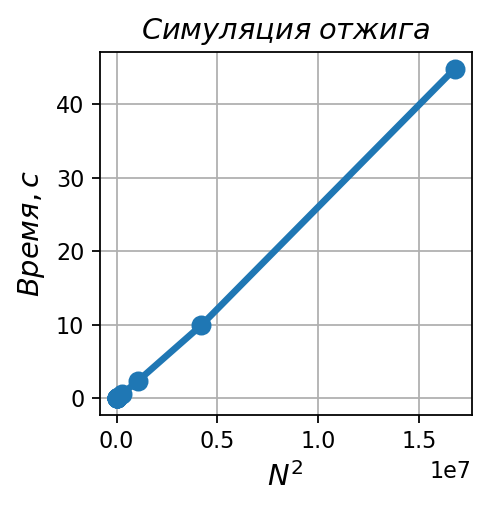

In [62]:
def plot_beautyful(x_arr, y_arr, x_label = None, y_label = None, title = None, x_size = 15, y_size = 15, title_size = 17, figsize = (6,6), labelsize= 16 ):
    plt.figure(figsize=figsize, dpi=160)
    plt.plot(x_arr, y_arr, linewidth = 3, marker = 'o', markersize = 8)
    plt.xlabel(x_label, fontsize=x_size)
    plt.ylabel(y_label, fontsize=y_size)
    plt.xticks(labelsize = labelsize)
    plt.yticks(labelsize = labelsize)
    plt.title(title, fontsize=title_size)
    plt.grid()
    plt.show()
    
plot_beautyful(2**(np.array(N_list_e)), exact_list, x_label = r'$2^{N}$', y_label = r'$Время, с$', title = r'$Точное \; решение \; перебором$', x_size = 13, y_size = 13, title_size = 13, figsize = (3,3), labelsize= 16 )
plot_beautyful(np.array(N_list)**2, sim_list, x_label = r'$N^{2}$', y_label = r'$Время, с$', title = r'$Симуляция \; отжига$', x_size = 13, y_size = 13, title_size = 13, figsize = (3,3), labelsize= 16 )

In [92]:
2**(-9), sim_list[1]

(0.001953125, 0.001943349838256836)

In [17]:
# t = timi.time()
# Q = {t: random.uniform(-1, 1) for t in itertools.product(range(qubo_size), repeat=2)}
# sampler = neal.SimulatedAnnealingSampler()
# response = QBSolv().sample_qubo(Q, solver=sampler, solver_limit=subqubo_size)
# print(response.first.energy, timi.time() - t)

In [18]:
t = time.time()
sampler = neal.SimulatedAnnealingSampler()
response = QBSolv().sample_qubo(Q, solver=sampler, solver_limit=subqubo_size)
print(response.first.energy, time.time() - t)

-7623.538860318017 5.486204624176025


In [ ]:
from dwave.system import DWaveSampler
sampler_manual = DWaveSampler(solver={'topology__type': 'chimera'})

In [6]:
from dwave_qbsolv import QBSolv


In [74]:
# qubo_size = market.N
# subqubo_size = 20

# embedding = busclique.find_clique_embedding(nodes = 20, g = C)
# print('start')
# # sampler = FixedEmbeddingComposite(DWaveSampler(solver = {'topology': {'type': 'pegasus', 'shape': [16]}, 'chip_id': 'Advantage_system4.1'}), embedding)
# # sampler = DWaveCliqueSampler()
# sampler = EmbeddingComposite(DWaveSampler())

# print('ready')
 
# t = time.time()
# response2 = QBSolv().sample_ising(h, J, solver=sampler, solver_limit=subqubo_size)
# t1 = time.time()

In [75]:
# t - t1

In [76]:
# DWaveSampler(solver = {'topology': {'type': 'chimera', 'shape': [16,16,4]}}).properties
# DWaveSampler().properties

In [77]:
# DWaveSampler(solver = {'topology': {'type': 'pegasus', 'shape': [16]}, 'chip_id': 'Advantage_system4.1'}).properties

In [7]:
from dwave.system import LeapHybridSampler

# solver2 = LeapHybridSampler()
solver = LeapHybridSampler.default_solver
solver.update(name__regex=".*(?<!bulk)$")       # name shouldn't end with "bulk"
solver2 = LeapHybridSampler(solver=solver)      
solver2.solver        

BQMSolver(id='hybrid_binary_quadratic_model_version2')

In [9]:
solver2.properties

{'minimum_time_limit': [[1, 3.0],
  [1024, 3.0],
  [4096, 10.0],
  [10000, 40.0],
  [30000, 200.0],
  [100000, 600.0],
  [1000000, 600.0]],
 'maximum_time_limit_hrs': 24.0,
 'maximum_number_of_variables': 1000000,
 'maximum_number_of_biases': 200000000,
 'parameters': {'time_limit': 'Maximum requested runtime in seconds.'},
 'supported_problem_types': ['bqm'],
 'category': 'hybrid',
 'version': '2.0',
 'quota_conversion_rate': 20}

In [79]:
# solver1 = FixedEmbeddingComposite(DWaveSampler(solver = {'topology': {'type': 'pegasus', 'shape': [16]}, 'chip_id': 'Advantage_system4.1'}), embedding)
# solver3 = DWaveCliqueSampler(config = Client.from_config())
# solver2 = EmbeddingComposite(DWaveSampler(config = Client.from_config()))
sampler = neal.SimulatedAnnealingSampler()


t0 = time.time()

# computation1 = solver1.sample_ising(h, J, num_reads=10)

t1 = time.time()

computation2 = solver2.sample_ising(h, J)

t2 = time.time()

# computation3 = solver3.sample_ising(h, J, num_reads=10)

t3 = time.time()

computation4 = sampler.sample_ising(h, J)

t4 = time.time()

In [80]:
print(t1-t0,t2-t1,t3-t2, t4-t3)

2.8133392333984375e-05 7.376812696456909 0.00013113021850585938 0.6300864219665527


In [66]:
computation2.first.energy, computation4.first.energy

(-44.453110664828074, -44.45311066482823)

In [67]:
computation2.info

{'qpu_access_time': 44480,
 'charge_time': 2989687,
 'run_time': 2989687,
 'problem_id': 'ff8a7d6b-5338-4714-8875-318a12447fc7'}

In [5]:
from dwave_qbsolv import QBSolv
import neal
import itertools
import random

In [11]:
# qubo_size = 20
# Q = {t: random.uniform(-1, 1) for t in itertools.product(range(qubo_size), repeat=2)}
# Q

In [ ]:
from dwave_qbsolv import QBSolv
import neal
import itertools
import random

# response2 = QBSolv().sample_ising(h, J, solver=sampler, solver_limit=subqubo_size)

qubo_size = 10000
subqubo_size = 5
Q = {t: random.uniform(-1, 1) for t in itertools.product(range(qubo_size), repeat=2)}
sampler = neal.SimulatedAnnealingSampler()
# sampler = EmbeddingComposite(DWaveSampler())

t0 = time.time()
response1 = sampler.sample_qubo(Q)
t1 = time.time()
# response2 = solver2.sample_qubo(Q) 
# response2 = QBSolv().sample_qubo(Q, solver=sampler, solver_limit=subqubo_size)
t2 = time.time()

In [20]:
t1 - t0, t2 - t1

(38.06505990028381, 4.100799560546875e-05)

In [ ]:
 53.707990407943726

In [ ]:
response1.first.energy, response2.first.energy

In [16]:
computation2.info.keys()

dict_keys(['beta_range', 'beta_schedule_type'])

In [ ]:
EmbeddingComposite(DWaveSampler(solver={'qpu': True})).find_embedding()